In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msn
import dexplot as dxp

In [2]:
import numpy as np
from scipy.stats import spearmanr
from datetime import timedelta

In [3]:

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

In [4]:
###reading in training set

train=pd.read_csv("training_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")


In [5]:
## dropping columns with high nulls

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]



#creating dependant variabe 

conditions = [
    #(train['booking_bool']> 0),
    (train['click_bool']> 0)
]
#choices = [500+(40 - train['position']) ,100+(40 - train['position'])]
#train['outcome'] = np.select(conditions, choices, default=(40 - train['position'])
#choices = [2 ,1]
choices = [1]
train['outcome'] = np.select(conditions, choices, default=0)

train = train.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)

#filtering out price outliers 
train = train[train.price_usd < 3001]

In [6]:
    ## creating time related features
    
    train['date_time'] = pd.to_datetime(train['date_time'], errors='coerce')
    train["weekday"] = train["date_time"].dt.weekday
    train["week_of_year"] = train["date_time"].dt.week
    train["month"] = train["date_time"].dt.month
    train["hour"] = train["date_time"].dt.hour
    ## total time elapsed - allows model to learn continous trend over time to a degree
    train["time_epoch"] = train["date_time"].astype('int64')//1e9
    train.loc[ train['hour'] < 6, 'day_time'] = 1
    train.loc[(train['hour'] >=6) & (train['hour'] <= 11), 'day_time'] = 2
    train.loc[(train['hour'] >= 12) & (train['hour'] <= 17), 'day_time'] = 3
    train.loc[(train['hour'] > 18) , 'day_time'] = 4

C:\Users\Admin\AppData\Local\Temp\ipykernel_7828\2701560120.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["week_of_year"] = train["date_time"].dt.week


In [7]:
#more time related features

train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
train["srch_for_month"] = train["srch_for_date"].dt.month
train.loc[ train['srch_for_month'] <= 3, 'seasonality'] = 1
train.loc[(train['srch_for_month'] > 3) & (train['srch_for_month'] <= 6), 'seasonality'] = 2
train.loc[(train['srch_for_month'] > 6) & (train['srch_for_month'] <= 9), 'seasonality'] = 3
train.loc[(train['srch_for_month'] > 9) , 'seasonality'] = 4

train.loc[ train['month'] <= 3, 'qrtr'] = 1
train.loc[(train['month'] > 3) & (train['month'] <= 6), 'qrtr'] = 2
train.loc[(train['month'] > 6) & (train['month'] <= 9), 'qrtr'] = 3
train.loc[(train['month'] > 9) , 'qrtr'] = 4

In [8]:
#filling in missing values for prop_review_score and prop_starrating using average rating 
#based off similar priced hotels 
train['price_bin'] = pd.qcut(train['price_usd'], q=80, precision=0)
train['mean_price_bin_star'] = train.groupby('price_bin')['prop_starrating'].transform('mean')
train['mean_price_bin_review'] = train.groupby('price_bin')['prop_review_score'].transform('mean')
train['prop_review_score'] = train['prop_review_score'].fillna(0)
train.loc[train.prop_review_score == 0, "prop_review_score"] = train.mean_price_bin_review
train.loc[train.prop_starrating == 0, "prop_starrating"] = train.mean_price_bin_star



In [9]:
#comparing price for hotels with other hotels in the same search

train['max_price'] = train.groupby('srch_id')['price_usd'].transform('max') 
train['min_price'] = train.groupby('srch_id')['price_usd'].transform('min') 
train['mean_price'] = train.groupby('srch_id')['price_usd'].transform('mean') 
train['diff_max_price'] =(train['max_price'] -train['price_usd']) / train['price_usd']
train['diff_min_price'] = (train['min_price'] - train['price_usd'])/ train['price_usd']
train['diff_min_price'] = train['diff_min_price'].replace(np.nan, 0)
train['diff_mean_price'] = (train['mean_price'] - train['price_usd']) / train['price_usd']
train['price_review_value'] =  train['prop_review_score'] /train['mean_price_bin_review'] 


In [10]:
# getting actual click and booking statistics for each hotel & if there was a booking - how many adults,children,rooms

train['hotel_show_prob'] =  train.groupby('prop_id')['prop_id'].transform('count') / (train.srch_id.unique()).size
train_calcs = train[train.booking_bool == 1]
train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean') 
train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean') 
train_calcs['hotel_avg_stay'] = train_calcs.groupby('prop_id')['srch_length_of_stay'].transform('mean') 
train_calcs['hotel_avg_room_count'] = train_calcs.groupby('prop_id')['srch_room_count'].transform('mean') 
train_calcs['bought'] = train_calcs.groupby('prop_id')['booking_bool'].transform('sum') 
train_calcs = train_calcs[['prop_id','hotel_avg_children', 'hotel_avg_adult', 'hotel_avg_stay','hotel_avg_room_count','bought']]

#pd.crosstab(train.hotel_click_prob, train.prop_id, dropna=False)
train_calcs = train_calcs.drop_duplicates(subset=['prop_id'])

train['hotel_buy_prob'] = train.groupby('prop_id')['booking_bool'].transform('sum') / train.groupby('prop_id')['booking_bool'].transform('count')
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_qrtr_buy_prob'] = train.groupby(['qrtr','prop_id'])['booking_bool'].transform('sum') / train.groupby(['qrtr','prop_id'])['booking_bool'].transform('count')
train['hotel_qrtr_click_prob'] = train.groupby(['qrtr','prop_id'])['click_bool'].transform('sum') / train.groupby(['qrtr','prop_id'])['click_bool'].transform('count')
train['hotel_srch_sesn_buy_prob'] = train.groupby(['seasonality','prop_id'])['booking_bool'].transform('sum') / train.groupby(['seasonality','prop_id'])['booking_bool'].transform('count')
train['hotel_srch_sesn_click_prob'] = train.groupby(['seasonality','prop_id'])['click_bool'].transform('sum') / train.groupby(['seasonality','prop_id'])['click_bool'].transform('count')


hotel_click_stats = train[['prop_id', 'hotel_buy_prob','hotel_click_prob', 'hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_7828\56183062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_children'] = train_calcs.groupby('prop_id')['srch_children_count'].transform('mean')
C:\Users\Admin\AppData\Local\Temp\ipykernel_7828\56183062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_calcs['hotel_avg_adult'] = train_calcs.groupby('prop_id')['srch_adults_count'].transform('mean')
C:\Users\Admin\AppData\Local\Temp\ipykernel_7828\56183062.py:7: SettingWithCopyWa

In [11]:
## balancing the dataset - at first balanced it 50:50 but now balancing it 33:66

#train_reduced = train.groupby('outcome')
#print(train_reduced.size().min()*2)
#train_reduced = pd.DataFrame(train_reduced.apply(lambda x: x.sample((train_reduced.size().min()*2),  replace=True).reset_index(drop=True)))
#train_reduced = pd.DataFrame(train_reduced.apply(lambda x: x.sample((train_reduced.size().min()),  replace=True).reset_index(drop=True)))

df = train[train.outcome == 1]
df1 = train[train.outcome == 0]
df1 = df1.sample(n=len(df)*2)

frames = [df, df1]

train_reduced = pd.concat(frames)

In [12]:
### merging hotel specific cals to main dataset 
train_reduced = train_reduced.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')
train_reduced['hotel_avg_children'] = train_reduced['hotel_avg_children'].replace(np.nan, .367)
train_reduced['hotel_avg_adult'] = train_reduced['hotel_avg_adult'].replace(np.nan, 1.95)
train_reduced['hotel_avg_stay'] = train_reduced['hotel_avg_stay'].replace(np.nan, 2.09)
train_reduced['hotel_avg_room_count'] = train_reduced['hotel_avg_room_count'].replace(np.nan, 1.13)


In [13]:
train_reduced.head(10)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,hotel_click_prob,hotel_qrtr_buy_prob,hotel_qrtr_click_prob,hotel_srch_sesn_buy_prob,hotel_srch_sesn_click_prob,hotel_avg_children,hotel_avg_adult,hotel_avg_stay,hotel_avg_room_count,bought
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2.0,3.0,...,0.034305,0.032258,0.046083,0.038278,0.047847,0.176471,2.058824,1.235294,1.176471,17.0
1,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,139893,2.0,3.0,...,0.033520,0.000000,0.035088,0.027523,0.036697,0.285714,2.142857,1.285714,1.285714,7.0
2,6,2013-06-05 12:27:51,14,100,NaN,NaN,100,104251,3.0,4.0,...,0.045455,0.071429,0.071429,0.090909,0.090909,0.000000,2.000000,1.000000,1.000000,1.0
3,8,2013-03-20 17:50:44,5,219,NaN,NaN,219,27669,3.0,3.5,...,0.035897,0.049383,0.061728,0.040541,0.040541,0.166667,1.666667,1.833333,1.000000,6.0
4,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,20499,2.0,3.5,...,0.030612,0.000000,0.026316,0.026316,0.052632,0.000000,2.000000,1.000000,1.000000,1.0
5,12,2013-03-15 14:55:16,5,219,NaN,NaN,158,129310,3.0,3.5,...,0.050000,0.000000,0.125000,0.000000,0.166667,0.367000,1.950000,2.090000,1.130000,NaN
6,17,2012-11-05 19:52:18,18,129,NaN,NaN,31,87596,3.0,2.5,...,0.045455,0.000000,0.040000,0.000000,0.041667,0.367000,1.950000,2.090000,1.130000,NaN
7,21,2013-02-18 17:16:25,15,55,NaN,NaN,216,61662,3.0,3.5,...,0.061224,0.111111,0.111111,0.142857,0.142857,0.666667,1.000000,4.333333,1.333333,3.0
8,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,23228,4.0,4.0,...,0.108108,0.181818,0.212121,0.200000,0.233333,0.111111,2.000000,2.000000,1.333333,9.0
9,28,2012-11-26 10:13:17,5,219,NaN,NaN,219,13996,4.0,4.0,...,0.035971,0.066667,0.066667,0.048780,0.048780,1.000000,1.750000,1.750000,1.000000,8.0


In [14]:
#dropped price bin
train_reduced = train_reduced.drop(['price_bin'], axis = 1)
#train_reduced.to_csv('hotel_calcs2.csv')

In [15]:
#checking %% of nulls in the dataset 
train_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.975853
                                 ...    
hotel_avg_children              0.000000
hotel_avg_adult                 0.000000
hotel_avg_stay                  0.000000
hotel_avg_room_count            0.000000
bought                         20.441806
Length: 62, dtype: float64

<AxesSubplot:>

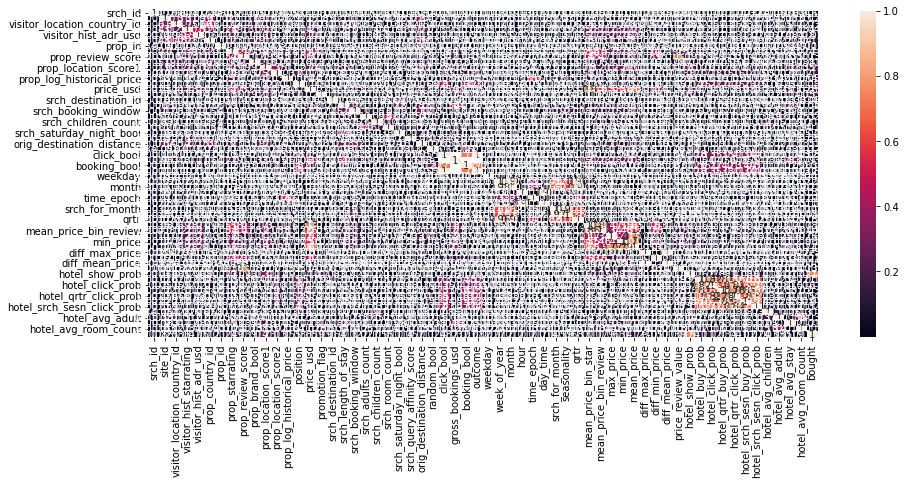

In [16]:
plt.figure(figsize=(15, 6))
sns.heatmap(train_reduced.corr().abs(),  annot=True)

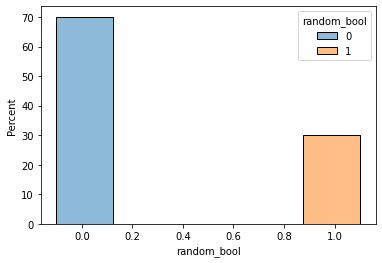

In [17]:
###### next few sections are some general charts exploring the data

ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'] ,
                  stat = 'percent', shrink =10, common_norm=True)

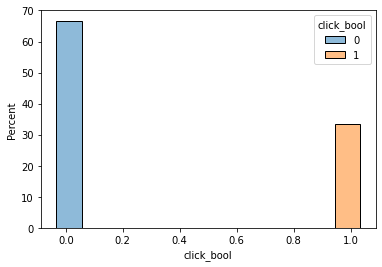

In [18]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['click_bool'], hue=train_reduced['click_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)

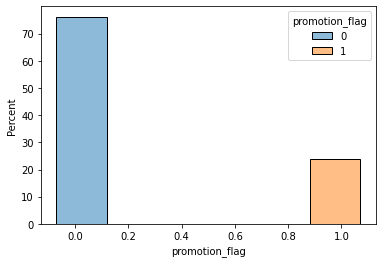

In [19]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['promotion_flag'], hue=train_reduced['promotion_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [20]:
# train_reduced['bought_flag'] = np.where(train_reduced['gross_bookings_usd']> 0, 1, 0)

# ax = sns.histplot(x = train_reduced['bought_flag'], hue=train_reduced['bought_flag'] ,
#                   stat = 'percent', shrink =4,common_norm=True)


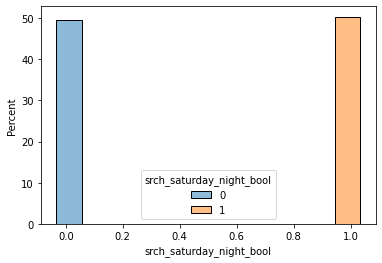

In [21]:


ax = sns.histplot(x = train_reduced['srch_saturday_night_bool'], hue=train_reduced['srch_saturday_night_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)


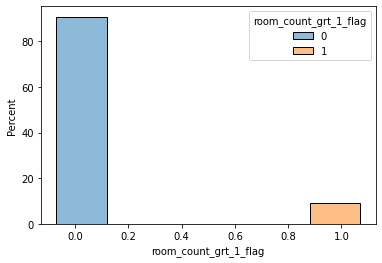

In [22]:
train_reduced['room_count_grt_1_flag'] = np.where(train_reduced['srch_room_count']> 1, 1, 0)

ax = sns.histplot(x = train_reduced['room_count_grt_1_flag'], hue=train_reduced['room_count_grt_1_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [23]:
# df = train_reduced.loc[(train_reduced['gross_bookings_usd'] >= 0) & (train_reduced['gross_bookings_usd'] <= 1000)]
# sns.kdeplot(df['gross_bookings_usd'])
# plt.show()

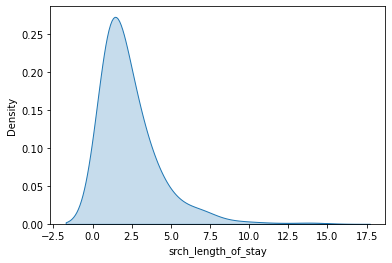

In [24]:
df = train_reduced.loc[(train_reduced['srch_length_of_stay'] >= 0) & (train_reduced['srch_length_of_stay'] <= 15)]
sns.kdeplot(df['srch_length_of_stay'], shade=True, bw_adjust=7)
plt.show()

In [25]:
##droppping columns not needed 

to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'room_count_grt_1_flag', 'booking_bool', 'srch_destination_id', 'position', 'prop_location_score2'
          ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought', 'weekday', 'week_of_year', 'hour', 'time_epoch'] 

train1 = train_reduced.drop(to_drop,  axis=1)



<AxesSubplot:>

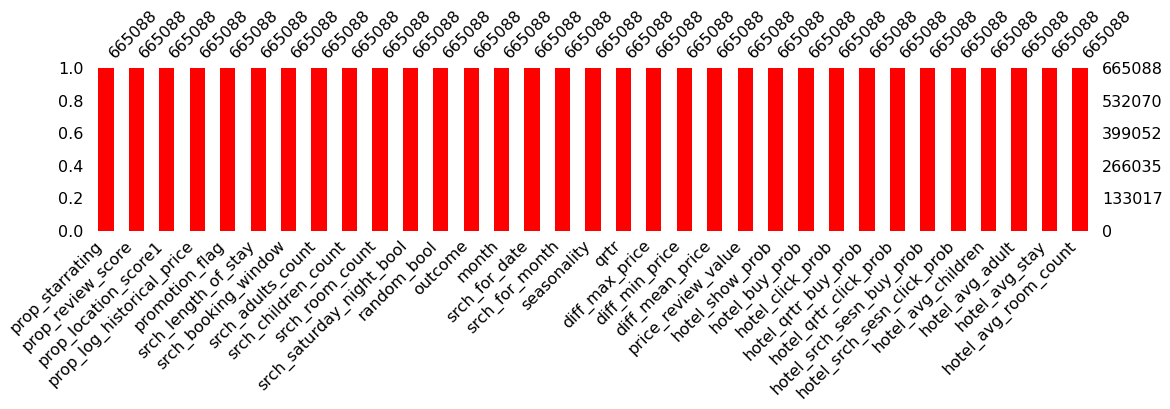

In [26]:

##changing nan or null values to 0
train1.replace([np.inf, -np.inf], 0, inplace=True)

train1=train1.dropna(axis=1,how="any")
msn.bar(train1,figsize=(18,3), color='red')

In [27]:
##ordering columns and selecting predictors + outcome
train1 = train1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob','outcome']]

In [28]:
#splitting dataset 
X = train1.iloc[:, :-1].values
y = train1.iloc[:, -1].values

In [29]:
train1.head(20)

,prop_starrating,prop_location_score1,prop_log_historical_price,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,...,hotel_avg_adult,hotel_avg_stay,hotel_avg_room_count,random_bool,qrtr,hotel_qrtr_click_prob,hotel_qrtr_buy_prob,hotel_srch_sesn_buy_prob,hotel_srch_sesn_click_prob,outcome
0,2.0,2.20,4.44,0,1,0,4,0,1,1,...,2.058824,1.235294,1.176471,1,2.0,0.046083,0.032258,0.038278,0.047847,1
1,2.0,1.61,5.25,0,2,46,1,0,1,1,...,2.142857,1.285714,1.285714,1,4.0,0.035088,0.000000,0.027523,0.036697,1
2,3.0,1.95,0.00,0,1,5,2,0,1,0,...,2.000000,1.000000,1.000000,0,2.0,0.071429,0.071429,0.090909,0.090909,1
3,3.0,3.00,4.62,0,1,0,1,0,1,0,...,1.666667,1.833333,1.000000,0,1.0,0.061728,0.049383,0.040541,0.040541,1
4,2.0,2.20,4.11,0,1,39,2,0,1,1,...,2.000000,1.000000,1.000000,1,1.0,0.026316,0.000000,0.026316,0.052632,1
5,3.0,0.00,3.75,0,2,21,3,0,1,1,...,1.950000,2.090000,1.130000,1,1.0,0.125000,0.000000,0.000000,0.166667,1
6,3.0,6.91,5.07,0,4,194,4,1,2,1,...,1.950000,2.090000,1.130000,1,4.0,0.040000,0.000000,0.000000,0.041667,1
7,3.0,4.04,4.54,1,4,62,1,0,1,0,...,1.000000,4.333333,1.333333,0,1.0,0.111111,0.111111,0.142857,0.142857,1
8,4.0,3.26,4.44,1,1,0,2,0,1,0,...,2.000000,2.000000,1.333333,0,4.0,0.212121,0.181818,0.200000,0.233333,1
9,4.0,2.89,5.07,0,3,27,1,0,1,0,...,1.750000,1.750000,1.000000,0,4.0,0.066667,0.066667,0.048780,0.048780,1


In [30]:

##list of models we can use, can take along time to do them all so try one or two at a time. 

models_list=[
    LogisticRegression(),
  #  Lasso(),
   # RandomForestClassifier(criterion='entropy', min_samples_leaf=60,
             #          min_samples_split=4, random_state=16),
    #GradientBoostingClassifier(),
    lgb.LGBMClassifier(),
   # LinearSVC(random_state=42, C=0.01),
    #xgb.XGBRegressor(objective="reg:linear", random_state=42)   
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.1), 
 #   xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.05), #better. 
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.01), 
    #  "multi:softprob"
]

In [31]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [32]:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

#loop thorugh list of models to use. Train them and give an acuracy score

import warnings
warnings.filterwarnings('ignore')

l=[]
for model in models_list:
    #clf=clf_models(model)
    print(model)
    fit_model=model.fit(X_train, y_train)
    score=model.score(X_test, y_test)
    print("model score: %.3f" % score)
    l.append([model,'clf', score, X_test, y_test])
    #print(clf)
    #scores = -1 * cross_val_score(clf, X, y,cv=5,scoring='neg_mean_absolute_error')
    #print("MAE scores:\n", scores.mean(), scores.sum(), scores.min())
    
#print(l[3][4])
#print(l[2][3])
#print(l[2][0])

LogisticRegression()
model score: 0.759
LGBMClassifier()
model score: 0.807


In [33]:
## using the lost of models we select on and use it to predict the test data with an output 

y_pred=l[1][0].predict(X_test)

print(y_pred)

y_pred[:5]

[0 1 1 ... 0 0 1]


array([0, 1, 1, 0, 0])

In [34]:
#list of features used in perdictions
predictors = ['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob', 'diff_max_price','diff_min_price','diff_mean_price', 'hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count', 'random_bool', 'qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob']

In [35]:
##importing tool to determine feature importance for the model 

from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    l[1][0], X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=predictors)

Elapsed time to compute the importances: 75.505 seconds


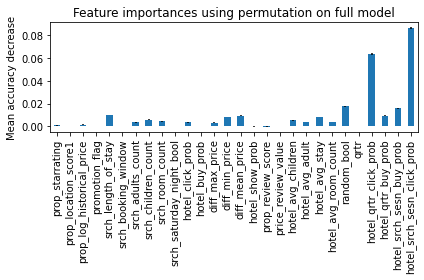

In [36]:
#graphing the impact each feature has on our perdiction - ie which features are the most useful 

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [37]:
# writing the results to a dataframe to analyse seperatly if needed ( ie how many false negatives, check values ect)

result = pd.DataFrame(y_test, columns=['actual'])
predicted= pd.DataFrame(y_pred, columns=['predicted'])

df = pd.DataFrame(X_test)
df['result'] = result
df['perdicted'] = predicted
df.to_csv('results2.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,result,perdicted
0,3.0,1.95,4.81,0.0,3.0,7.0,1.0,0.0,1.0,0.0,...,1.400000,1.000000,0.0,2.0,0.058824,0.058824,0.062500,0.062500,0,0
1,3.0,1.95,4.58,1.0,1.0,12.0,2.0,0.0,1.0,1.0,...,2.090000,1.130000,1.0,2.0,0.125000,0.000000,0.000000,0.100000,1,1
2,4.0,4.43,5.03,0.0,8.0,55.0,2.0,0.0,1.0,0.0,...,2.090000,1.130000,1.0,2.0,0.250000,0.000000,0.000000,0.285714,1,1
3,5.0,3.76,0.00,0.0,2.0,3.0,2.0,1.0,1.0,1.0,...,1.727273,1.090909,0.0,2.0,0.039024,0.029268,0.035533,0.045685,0,0
4,3.0,4.81,0.00,0.0,1.0,110.0,1.0,0.0,1.0,1.0,...,2.090000,1.130000,0.0,2.0,0.000000,0.000000,0.000000,0.083333,0,0


In [38]:
###################### pred 

In [39]:
#### import competition dataset 

to_pred=pd.read_csv("test_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")

to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]

#train['outcome'] = pd.Series(train['booking_bool']> 0, 500 + train['position'] , train['click_bool']> 0, 100 +train['position'] , 0 + train['position'] )



to_pred = to_pred.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)
#test_reduced  = test.iloc[: , :N].sample(frac=0.33, replace=True, random_state=1)


In [40]:
# creating same features as test data

to_pred['date_time'] = pd.to_datetime(to_pred['date_time'], errors='coerce')
to_pred["weekday"] = to_pred["date_time"].dt.weekday
to_pred["week_of_year"] = to_pred["date_time"].dt.week
to_pred["month"] = to_pred["date_time"].dt.month
to_pred["hour"] = to_pred["date_time"].dt.hour
to_pred["time_epoch"] = to_pred["date_time"].astype('int64')//1e9
to_pred["time_epoch"] = to_pred["date_time"].astype('int64')//1e9
to_pred.loc[ to_pred['hour'] < 6, 'day_time'] = 1
to_pred.loc[(to_pred['hour'] >=6) & (to_pred['hour'] <= 11), 'day_time'] = 2
to_pred.loc[(to_pred['hour'] >= 12) & (to_pred['hour'] <= 17), 'day_time'] = 3
to_pred.loc[(to_pred['hour'] > 18) , 'day_time'] = 4

##################

to_pred['srch_for_date'] = to_pred['date_time']  + pd.to_timedelta(to_pred['srch_booking_window'], unit='D')
to_pred["srch_for_month"] = to_pred["srch_for_date"].dt.month

#train['srch_for_date'] = train['date_time']  + pd.to_timedelta(train['srch_booking_window'], unit='D')
#train["srch_for_month"] = train["srch_for_date"].dt.month
to_pred.loc[ to_pred['srch_for_month'] <= 3, 'seasonality'] = 1
to_pred.loc[(to_pred['srch_for_month'] > 3) & (to_pred['srch_for_month'] <= 6), 'seasonality'] = 2
to_pred.loc[(to_pred['srch_for_month'] > 6) & (to_pred['srch_for_month'] <= 9), 'seasonality'] = 3
to_pred.loc[(to_pred['srch_for_month'] > 9) , 'seasonality'] = 4

to_pred.loc[ to_pred['month'] <= 3, 'qrtr'] = 1
to_pred.loc[(to_pred['month'] > 3) & (to_pred['month'] <= 6), 'qrtr'] = 2
to_pred.loc[(to_pred['month'] > 6) & (to_pred['month'] <= 9), 'qrtr'] = 3
to_pred.loc[(to_pred['month'] > 9) , 'qrtr'] = 4

####################

to_pred['price_bin'] = pd.qcut(to_pred['price_usd'], q=80, precision=0)
to_pred['mean_price_bin_star'] = to_pred.groupby('price_bin')['prop_starrating'].transform('mean')
to_pred['mean_price_bin_review'] = to_pred.groupby('price_bin')['prop_review_score'].transform('mean')
to_pred['prop_review_score'] = to_pred['prop_review_score'].fillna(0)
to_pred.loc[to_pred.prop_review_score == 0, "prop_review_score"] = to_pred.mean_price_bin_review
to_pred.loc[to_pred.prop_starrating == 0, "prop_starrating"] = to_pred.mean_price_bin_star

##################

to_pred['max_price'] = to_pred.groupby('srch_id')['price_usd'].transform('max') 
to_pred['min_price'] = to_pred.groupby('srch_id')['price_usd'].transform('min') 
to_pred['mean_price'] = to_pred.groupby('srch_id')['price_usd'].transform('mean') 
to_pred['diff_max_price'] =(to_pred['max_price'] -to_pred['price_usd']) / to_pred['price_usd']
to_pred['diff_min_price'] = (to_pred['min_price'] - to_pred['price_usd'])/ to_pred['price_usd']
to_pred['diff_min_price'] = to_pred['diff_min_price'].replace(np.nan, 0)
to_pred['diff_mean_price'] = (to_pred['mean_price'] - to_pred['price_usd']) / to_pred['price_usd']
to_pred['price_review_value'] =  to_pred['prop_review_score'] /to_pred['mean_price_bin_review'] 

#################

to_pred['hotel_show_prob'] =  to_pred.groupby('prop_id')['prop_id'].transform('count') / (to_pred.srch_id.unique()).size


In [41]:
### mergeing hotel specific stats from test dataset 

to_pred_reduced = to_pred.merge(train_calcs, left_on=['prop_id'], right_on=['prop_id'], how='left')
hotel_click_stats = hotel_click_stats.drop_duplicates(subset=['prop_id'])
to_pred_reduced = to_pred_reduced.merge(hotel_click_stats, left_on=['prop_id'], right_on=['prop_id'], how='left')

In [42]:


#train_reduced = train_reduced.merge(train_clacs, on='prop_id', how='right', suffixes=('_1', '_2'))
#to_pred_reduced  = pd.concat([to_pred_reduced.set_index('prop_id'),train_calcs.set_index('prop_id')], axis=1, join='outer').reset_index()
#to_pred_reduced2  = pd.concat([to_pred_reduced.set_index('prop_id'),hotel_click_stats.set_index('prop_id')], axis=1, join='outer').reset_index()
to_pred_reduced['hotel_avg_children'] = to_pred_reduced['hotel_avg_children'].replace(np.nan, .367)
to_pred_reduced['hotel_avg_adult'] = to_pred_reduced['hotel_avg_adult'].replace(np.nan, 1.95)
to_pred_reduced['hotel_avg_stay'] = to_pred_reduced['hotel_avg_stay'].replace(np.nan, 2.09)
to_pred_reduced['hotel_avg_room_count'] = to_pred_reduced['hotel_avg_room_count'].replace(np.nan, 1.13)
to_pred_reduced[['hotel_click_prob', 'hotel_buy_prob']] = to_pred_reduced[['hotel_click_prob', 'hotel_buy_prob']].fillna(0)


#train_reduced.to_csv('hotel_calcs2.csv')

In [43]:
to_pred_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.889662
visitor_hist_adr_usd           94.865606
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.000000
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           21.939743
prop_log_historical_price       0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affinity_score      93.584467
orig_destination

In [44]:
###droppping unused columns 

to_drop = ['site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id','price_bin', 'prop_brand_bool', 'orig_destination_distance', 'srch_destination_id', 'prop_location_score2'
          ,'price_usd','price_bin', 'max_price', 'srch_query_affinity_score','visitor_hist_starrating', 'visitor_hist_adr_usd', 'min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'bought',  'weekday', 'week_of_year', 'hour', 'time_epoch'] 

to_pred1 = to_pred_reduced.drop(to_drop,  axis=1)

<AxesSubplot:>

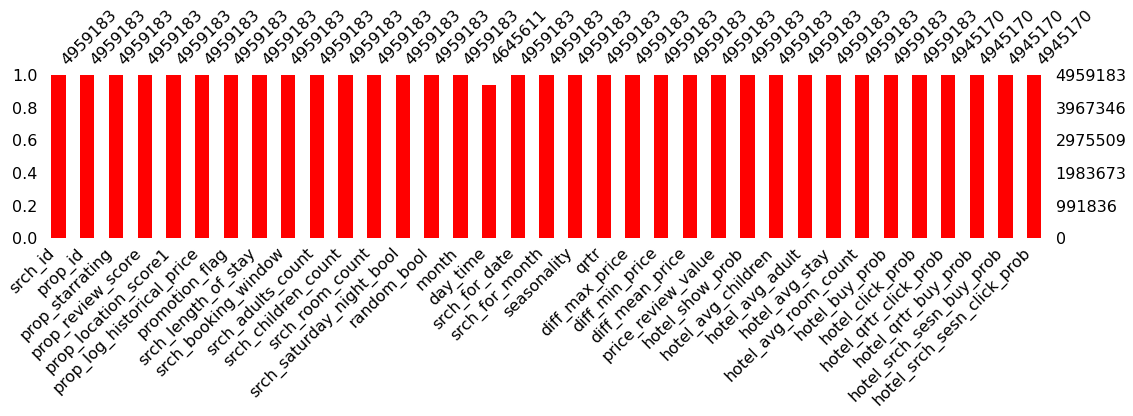

In [45]:
msn.bar(to_pred1,figsize=(18,3), color='red')

<AxesSubplot:>

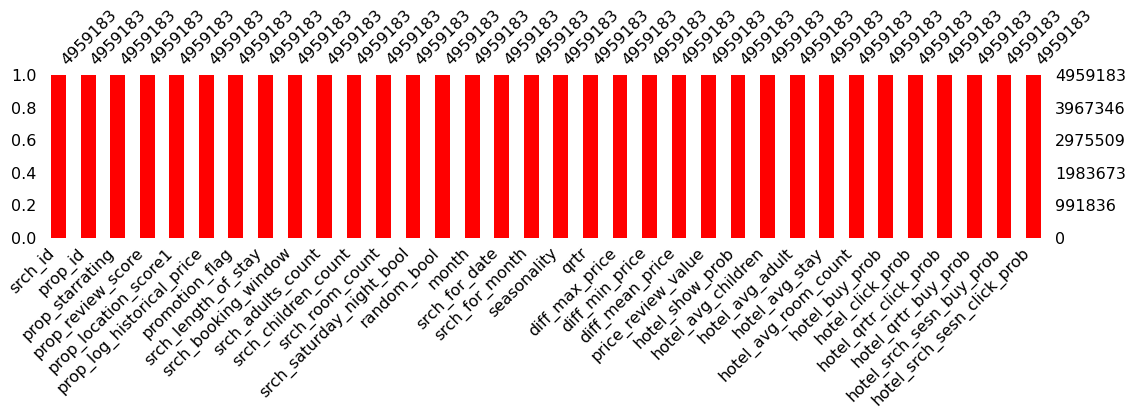

In [46]:
#replacing nulls and nans

to_pred1.replace([np.inf, -np.inf], 0, inplace=True)

to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']] = to_pred1[['hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob', 'hotel_srch_sesn_click_prob']].replace(np.nan, 0)

to_pred1=to_pred1.dropna(axis=1,how="any")
msn.bar(to_pred1,figsize=(18,3), color='red')

In [47]:
##ordering df and selecting predictors
to_pred1 = to_pred1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_review_score','price_review_value', 'hotel_avg_children','hotel_avg_adult','hotel_avg_stay','hotel_avg_room_count','random_bool','qrtr','hotel_qrtr_click_prob', 'hotel_qrtr_buy_prob', 'hotel_srch_sesn_buy_prob','hotel_srch_sesn_click_prob', 'srch_id', 'prop_id']]

In [48]:
to_pred1.dtypes

prop_starrating               float64
prop_location_score1          float64
prop_log_historical_price     float64
promotion_flag                  int64
srch_length_of_stay             int64
srch_booking_window             int64
srch_adults_count               int64
srch_children_count             int64
srch_room_count                 int64
srch_saturday_night_bool        int64
hotel_click_prob              float64
hotel_buy_prob                float64
diff_max_price                float64
diff_min_price                float64
diff_mean_price               float64
hotel_show_prob               float64
prop_review_score             float64
price_review_value            float64
hotel_avg_children            float64
hotel_avg_adult               float64
hotel_avg_stay                float64
hotel_avg_room_count          float64
random_bool                     int64
qrtr                          float64
hotel_qrtr_click_prob         float64
hotel_qrtr_buy_prob           float64
hotel_srch_s

In [49]:
## saving serch_id and prod_id for use in submission file 

ids = to_pred1[['srch_id', 'prop_id']]

to_drop = ['srch_id','prop_id']

to_pred1 = to_pred1.drop(to_drop,  axis=1)

###### perdicitng outcome using model

y_pred=l[1][0].predict(to_pred1)

print(y_pred)

y_pred[:5]

[0 0 0 ... 0 1 0]


array([0, 0, 0, 0, 0])

In [50]:

###creating submission file

predicted= pd.DataFrame(y_pred, columns=['predicted'])

df = pd.DataFrame(to_pred1)

df['perdicted'] = predicted

df[['srch_id', 'prop_id']] = ids[['srch_id', 'prop_id']]

df = df[['srch_id', 'prop_id', 'perdicted','hotel_buy_prob']]

##ordering submission file 


df = df.sort_values(['srch_id', 'perdicted', 'hotel_buy_prob'],
              ascending = [True, False,False])
df = df.drop(['perdicted', 'hotel_buy_prob'], axis = 1)
df.to_csv('submission.csv', index=False)

df.head(5)

,srch_id,prop_id
5,1,28181
1,1,5543
9,1,54937
23,1,99484
0,1,3180
